In [43]:
import gymnasium as gym
import numpy as np

class DisturbedLunarLander(gym.Wrapper):
    def __init__(self, env, failure_prob=0.05, force_magnitude=10.0):
        super().__init__(env)
        self.failure_prob = failure_prob
        self.force_magnitude = force_magnitude

        # Unwrap to access the original LunarLander instance
        base = env
        while hasattr(base, "env"):
            base = base.env
        self.base_env = base  # This is now the actual LunarLander

    def step(self, action):
        # Random engine failure
        if np.random.rand() < self.failure_prob:
            action = 0  # Override with no-op

        obs, reward, terminated, truncated, info = self.env.step(action)

        # Random horizontal force
        if np.random.rand() < self.failure_prob:
            try:
                self.base_env.lander.ApplyForceToCenter(
                    (np.random.uniform(-self.force_magnitude, self.force_magnitude), 0),
                    True
                )
            except AttributeError:
                print("[Warning] lander not available at this step.")

        return obs, reward, terminated, truncated, info



In [84]:
class FuelEfficientLunarLander(gym.Wrapper):
    def __init__(self, env, fuel_costs=(0.3, 0.1, 0.1), fuel_penalty_weight=0.5):
        super().__init__(env)
        self.fuel_costs = fuel_costs  # (main_engine, left_engine, right_engine)
        self.fuel_penalty_weight = fuel_penalty_weight
        self.fuel = 0.0  # Fuel now unbounded but tracked

        # Extend observation space by 1 (for fuel used so far)
        low = np.append(self.observation_space.low, 0.0)
        high = np.append(self.observation_space.high, np.inf)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def reset(self, **kwargs):
        self.fuel = 0.0  # Reset fuel usage tracker
        obs, info = self.env.reset(**kwargs)
        return np.append(obs, self.fuel), info

    def step(self, action):
    # Calculate fuel cost
        fuel_used = 0.0
        if action == 1:  # Main engine
            fuel_used = self.fuel_costs[0]
        elif action == 2:  # Left engine
            fuel_used = self.fuel_costs[1]
        elif action == 3:  # Right engine
            fuel_used = self.fuel_costs[2]
    
        # Reduce fuel
        self.fuel = max(self.fuel - fuel_used, 0.0)
    
        # Replace action with 0 if fuel is gone
        if self.fuel <= 0:
            action = 0
    
        obs, reward, terminated, truncated, info = self.env.step(action)
    
        # Add fuel penalty to reward
        reward -= fuel_used * 0.4  # Less aggressive penalty
    
        # Optional: Reward for centered & smooth landing
        if terminated and info.get("lander_leg_contact", False):  # You may need to extract this from env
            reward += 70
    
        # Append fuel to observation
        obs = np.append(obs, self.fuel)
    
        # Optionally terminate if fuel runs out
        if self.fuel <= 0 and not terminated:
            terminated = True
            info["reason"] = "out_of_fuel"
    
        return obs, reward, terminated, truncated, info



In [79]:
import gymnasium as gym  # <-- Important!
import os
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.monitor import Monitor
log_dir ="./logs_f/"
os.makedirs(log_dir, exist_ok=True)


base_env = gym.make("LunarLander-v3")
env = DisturbedLunarLander(base_env, failure_prob=0.08, force_magnitude=20.0)
env = FuelAwareLunarLander(env, initial_fuel=100.0)
env = RecordEpisodeStatistics(env)
env = Monitor(env, log_dir) 





# Initialize DQN agent
model = DQN(
    "MlpPolicy",
    env,
    buffer_size=100000,
    learning_starts=10000,
    batch_size=128,
    exploration_fraction=0.2,
    target_update_interval=1000,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
)
model.learn(total_timesteps=500_000)

# Save model
model.save("dqn_lunarlander_f")


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 74.2     |
|    ep_rew_mean      | -259     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3831     |
|    time_elapsed     | 0        |
|    total_timesteps  | 297      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.1     |
|    ep_rew_mean      | -184     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4509     |
|    time_elapsed     | 0        |
|    total_timesteps  | 681      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.4     |
|    ep_rew_mean      | -182     |
|    exploration_rate | 0.99     |
| t

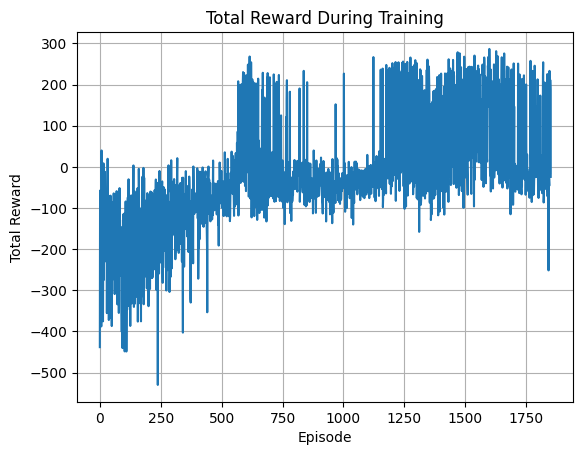

In [85]:
import pandas as pd

monitor_file = os.path.join(log_dir, "monitor.csv")
df = pd.read_csv(monitor_file, skiprows=1)  # First row is a comment

# Plot reward over episodes
plt.plot(df["r"])  # 'r' is total reward
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward During Training")
plt.grid(True)
plt.show()

In [81]:
import time


# Load environment with rendering
base_env = gym.make("LunarLander-v3", render_mode="human")
env = DisturbedLunarLander(base_env, failure_prob=0.08, force_magnitude=20.0)
env = FuelAwareLunarLander(env, initial_fuel=100.0)


# Load trained model
model = DQN.load("dqn_lunarlander_f_2", env=env)

obs, _ = env.reset()  # <-- FIXED: unpack obs and info
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)  # New Gym returns 5 items
    if done or truncated:
        obs, _ = env.reset()
    time.sleep(0.02)

env.close()


C:\Users\dastu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
C:\Users\dastu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [83]:
import gymnasium as gym
import numpy as np
import time
from stable_baselines3 import DQN



# Create disturbed environment
base_env = gym.make("LunarLander-v3", render_mode="human")
env = DisturbedLunarLander(base_env, failure_prob=0.08, force_magnitude=20.0)
env = FuelAwareLunarLander(env, initial_fuel=100.0)
model = DQN.load("dqn_lunarlander_f", env=env)

obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    time.sleep(0.02)


# Load trained model
model = DQN.load("dqn_lunarlander_f", env=env)

# Reset environment
obs, _ = env.reset()
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    # Optional: Highlight disturbances in the console
    if info.get("disturbed", False):
        print(f"[*] Disturbance handled | Force: {info['force']}")

    time.sleep(0.02)

    if done or truncated:
        print(">>> Episode finished. Resetting environment...\n")
        obs, _ = env.reset()
        #done = False

env.close()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
>>> Episode finished. Resetting environment...

